- Read data
- ID text col
* Vectorize
- Cluster
- Make column by assigining docs to cluster
- Write to csv
- ...
- DR ->
- Create project
- Upload data
- Ensure cluster feature is categorical?
- Run, compare to metrics without cluster

In [2]:
import pandas as pd
import numpy as np
import datarobot as dr
import topic_model
import os
from pprint import pprint

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Cluster the data (based on text data and NMF in this case)

In [21]:
# Dict of source data files and relevant text columns
sources = {
    '10kDiabetes': {
        'target': 'readmitted',
        'text_columns': ['diag_1_desc', 'diag_2_desc', 'diag_3_desc'],
        'kmeans_columns' : ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'num_medications']
    },
    '10K_Lending_Club_Loans': {
        'target': 'is_bad',
        'text_columns': ['emp_title', 'desc', 'purpose', 'title'],
        'kmeans_columns' : ['loan_amnt', 'funded_amnt', 'annual_inc', 'dti', 'open_acc', 'revol_bal']
    }
}

# Designate the source you want to use here:
source_used = '10kDiabetes'

# Read the data file
file_path = 'data/'
file_name = source_used
file_extn = '.csv'
df = pd.read_csv(file_path + file_name + file_extn, encoding = "ISO-8859-1")

# Source target
target = sources.get(source_used).get('target')

# Source text columns
text_columns = sources.get(source_used).get('text_columns')
kmeans_columns = sources.get(source_used).get('kmeans_columns')

### Cluster - topic model dibetes dataset

In [4]:
# For unsupervised topic modeling, we need text fields to cluster.
# The diabetes dataset has three unstructured text fields that comprise doctor/nurse/staff notes about the patient.
# We'll use this to cluster, and aggregate all three into one feature.

def make_docs(df, text_cols):    
    '''
    For each feature column in the dataframe, tokenize the words then combine each column
    into one pandas series
    
    Parameters:
        df - your dataframe
        text_colums - the colums to tokenize and aggregate
    
    Return:
        docs - a pandas series of text data
    '''
    text_col_data = []
    for col in text_cols:
        series = df[col]

        # tokenize the words in each text feature
        series = series.apply(lambda x: x.split() if type(x) == str else [])

        # Combine into one feature
        text_col_data.append(series)

    combined_cols = text_col_data[0]
    for i in range(1, len(text_col_data)):
        combined_cols = combined_cols + text_col_data[i]

    docs = combined_cols.apply(lambda x: ' '.join(x))
    
    return docs

docs = make_docs(df, text_columns)

# Add the combined text series 'docs' as a column in the dataframe
df['docs'] = docs

# There should be no null rows
print('Null rows:',docs[docs.isnull()].shape[0])
print('Not null:  %s' % docs[docs.notnull()].shape[0])

Null rows: 0
Not null:  10000


In [5]:
docs.head()

0                    Time Warner Cable medical Medical
1    Ottawa University Borrower added on 04/14/11 >...
2          Kennedy Wilson credit_card AP Personal Loan
3    TOWN OF PLATTEKILL debt_consolidation Debt Con...
4    Belmont Correctional I want to consolidate my ...
dtype: object

In [6]:
# Params to build the vocab and topics
min_df = 10
max_df = .1
max_vocab_size = 5000
ngram_range=(1,1)

tm = topic_model.NMF_TopicModeller(max_vocab_size=max_vocab_size, 
                                   min_df=min_df, 
                                   max_df=max_df, 
                                   ngram_range=ngram_range)
tm.vectorize(docs)

Number of documents to process: 10000

Extracting Vectorizer features...
- Time: 0.636s.



Processed NMF for k=20 of 20 - Time: 1.025s.
Existing word2vec Model loaded from './data/w2v-model.bin'
word2vec model has 1836 terms
Calculating coherence scores...
Optimal number of k topics: 12


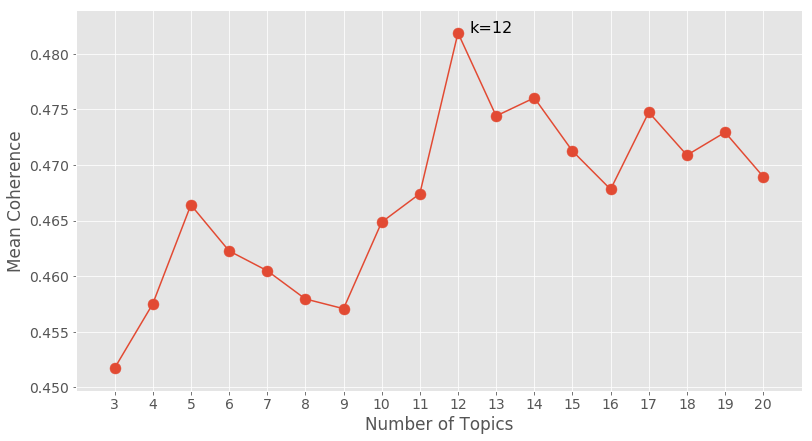

Topic 00: plan, good, use, stable, company, paid, lower, just, make, funds, want, income, work, late, looking
Topic 01: home_improvement, improvement, pool, kitchen, house, improvements, roof, new, bathroom, remodel, project, corp, remodeling, repair, swimming
Topic 02: wedding, expenses, ring, engagement, married, expense, honeymoon, fiance, reception, upcoming, used, getting, dream, planning, fiancee
Topic 03: car, auto, motorcycle, purchase, repairs, vehicle, used, repair, buy, new, llc, rent, honda, truck, miles
Topic 04: medical, center, expenses, regional, surgery, dental, group, procedure, expense, insurance, cover, hospital, work, american, health
Topic 05: business, small_business, small, equipment, capital, start, new, expansion, inventory, expand, company, starting, working, purchase, used
Topic 06: major_purchase, purchase, major, motorcycle, boat, new, investment, ring, bike, truck, university, vehicle, army, engagement, used
Topic 07: moving, expenses, relocation, new, co

In [7]:
# Calculate the optimal k using word2vec for coherence metric
k_topics = topic_model.plot_optimal_k(docs.tolist(), tm.document_term_mat, tm.vectorizer,
                           kmin=3, kmax=20, dim_size=500, min_df=min_df, 
                           max_vocab_size=max_vocab_size, num_top_terms=15,
                           model_file_path='./data/',
                           model_file_name='w2v-model.bin')

In [8]:
tm.fit(docs, k_topics=k_topics)

Fitting model with 10000 documents.  Vectorizer: 
TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=0.1, max_features=5000, min_df=10,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=frozenset({'fs', 'ai', 'nb', 'interest', 'og', 'fb', 'around', 'below', 'bn', 'py', 'wj', 'could', 'nu', 'jg', 'whom', 'well', 'thus', 'ij', 'ox', 'uv', 'fq', 'elsewhere', 'ph', 'si', 'ak', 'such', 'whenever', 'this', 'eight', 'bill', 'must', 'jn', 'a', 'i', 'kj', 'as', 'mp', 'yj', 'kz', ..., 'ax', 'jr', 'ee', 'rz', 'ours', 'xq', 'please', 'stated', 'st', 'js', 'there', 'iz', 'ud', 'get'}),
        strip_accents=None, sublinear_tf=False,
        token_pattern='(?ui)\\b[a-zA-Z]*[a-z]+\\w*\\b', tokenizer=None,
        use_idf=True, vocabulary=None)
- Time: 0.558s.



In [9]:
# Generate the probability of each topic for each row (eg, job posting)
# and add the top topic and probability to the dataframe
def get_normalized_probs(topic_weights):
    '''
    Return the normalized topic cluseter weights for a given row
    '''
    topic_weights = topic_weights.flatten()
    #print row_idx
    if topic_weights.sum() == 0:
        probs = topic_weights
    else:
        probs = (topic_weights / topic_weights.sum())
    return probs

# For each row, get the topic weights, normalize, order by
# weight value, and store in a list to add to the dataframe 
top_topics = []
top_topic_weights = []
for row_idx in range(tm.W.shape[0]):
    W = tm.W[row_idx]
    probs = get_normalized_probs(W)
    
    ordered_idxs = np.argsort(probs)[::-1]
    top_topics.append(ordered_idxs[0])
    top_topic_weights.append(probs[ordered_idxs[0]])
    
df['top_topic'] = top_topics
df['top_topic_weight'] = top_topic_weights

In [10]:
tm.W[1]

array([0.03179797, 0.        , 0.00316203, 0.        , 0.02019972,
       0.        , 0.        , 0.00587078, 0.        , 0.        ,
       0.        , 0.        ])

In [11]:
df.head()

,loan_amnt,funded_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,...,revol_bal,revol_util,total_acc,initial_list_status,mths_since_last_major_derog,policy_code,is_bad,docs,top_topic,top_topic_weight
0,4000,4000,60 months,7.29%,79.76,A,A4,Time Warner Cable,10+ years,MORTGAGE,...,12087,12.1,44.0,f,NaN,1,0,Time Warner Cable medical Medical,4,1.000000
1,16000,16000,60 months,18.25%,408.48,F,F1,Ottawa University,< 1 year,RENT,...,10114,64.0,5.0,f,NaN,1,0,Ottawa University Borrower added on 04/14/11 >...,0,0.521018
2,8700,8700,36 months,7.88%,272.15,A,A5,Kennedy Wilson,4 years,RENT,...,81,0.6,8.0,f,NaN,1,0,Kennedy Wilson credit_card AP Personal Loan,11,0.000000
3,18000,18000,60 months,11.49%,395.78,B,B4,TOWN OF PLATTEKILL,10+ years,MORTGAGE,...,10030,37.1,23.0,f,NaN,1,0,TOWN OF PLATTEKILL debt_consolidation Debt Con...,11,0.000000
4,16000,16000,36 months,11.83%,530.15,B,B3,Belmont Correctional,10+ years,MORTGAGE,...,10740,40.4,21.0,f,NaN,1,0,Belmont Correctional I want to consolidate my ...,9,0.886066


top topic value counts:
 0     4615
11    1378
1      703
5      555
3      534
6      479
4      396
10     322
2      321
8      313
7      238
9      146
Name: top_topic, dtype: int64


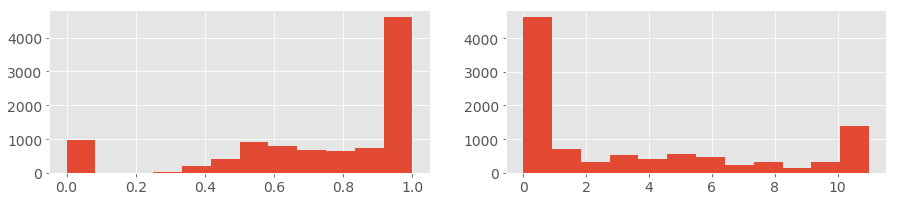

In [12]:
fig, axs = plt.subplots(1,2, figsize=(15,3))
df.top_topic_weight.hist(bins=k_topics, ax=axs[0])
df.top_topic.hist(bins=k_topics, ax=axs[1])
print('top topic value counts:\n',df.top_topic.value_counts())

Topic probabilities:
[0.52101774 0.         0.05181061 0.         0.33097744 0.
 0.         0.0961942  0.         0.         0.         0.        ]

Top Topic: 0

Text:
"Ottawa University Borrower added on 04/14/11 > I will be using this loan to pay off expenses accrued in the last six months on my credit cards, due to a combination of job transition, relocation for the job, and medical expenses from a broken tibula. I generally overpay my monthly minimum on my debts, so I expect that this loan will be repaid sooner than 5 years. I have a steady job working in the information technology field, I've been employed full-time in this field for over eight years, and have been with my present employer for seven months in good standing. My monthly budget breakdown is 1/3 of my paycheck going to rent and bills, 1/3 going to living and job transit expenses, and 1/3 remaining for general spending and payments.<br/> debt_consolidation My Debt Consolidation Loan"


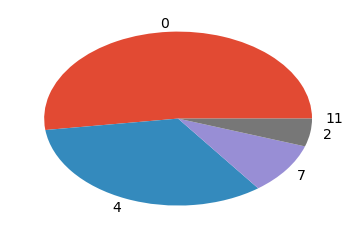

In [13]:
# Inspect record data
def inspect_record(rec_id):
    row_num = rec_id
    probs = get_normalized_probs(tm.W[row_num])
    ordered_idxs = np.argsort(probs)[::-1]
    top_topic = ordered_idxs[0]
    print ("Topic probabilities:\n%s\n" % probs)
    print ("Top Topic: %s\n" % top_topic)
#     print ("Top Tags:\n%s\n" % get_topic_top_tags(top_topic, 3))

    top_topics.append(ordered_idxs[0])
    top_topic_weights.append(probs[ordered_idxs[0]])
    plt.pie(probs[ordered_idxs[:5]], labels=ordered_idxs[:5])
    print('Text:\n\"%s\"' % df.iloc[row_num].docs)
inspect_record(1)

In [53]:
# Drop the docs column before writing to csv
df.drop(['docs'], axis=1, inplace=True)

# Write the dataframe to csv
file_with_topics = file_path + file_name + '_with_topics' + file_extn
df.to_csv(file_with_topics)

# Create a new DataRobot project with the new dataset with cluster features

In [55]:
dr.Client(token=os.environ['DATAROBOT_API_TOKEN'], endpoint=os.environ['DATAROBOT_ENDPOINT'])

In [56]:
# # Create a project: and upload the data, set the target, give the project a name
project = dr.Project.create(sourcedata=file_with_topics, 
                            project_name="{} with NMF topic clustering".format(source_used))

print('project id:  ', project.id)
print('project name:', project.project_name)
print('project.get_status():\n- ', project.get_status())

project id:   5b03b61d6cd83a1a565665fb
project name: 10K_Lending_Club_Loans with NMF topic clustering
project.get_status():
-  {'autopilot_done': False, 'stage_description': 'Ready to set target', 'stage': 'aim'}


In [57]:
# Output the identified project features# Outpu 
features = project.get_features()
sorted([f.name for f in features])

['Unnamed: 0',
 'addr_state',
 'annual_inc',
 'delinq_2yrs',
 'desc',
 'dti',
 'earliest_cr_line',
 'earliest_cr_line (Day of Month)',
 'earliest_cr_line (Day of Week)',
 'earliest_cr_line (Month)',
 'earliest_cr_line (Year)',
 'emp_length',
 'emp_title',
 'funded_amnt',
 'grade',
 'home_ownership',
 'initial_list_status',
 'inq_last_6mths',
 'installment',
 'int_rate',
 'is_bad',
 'loan_amnt',
 'mths_since_last_delinq',
 'mths_since_last_major_derog',
 'mths_since_last_record',
 'open_acc',
 'policy_code',
 'pub_rec',
 'purpose',
 'pymnt_plan',
 'revol_bal',
 'revol_util',
 'sub_grade',
 'term',
 'title',
 'top_topic',
 'top_topic_weight',
 'total_acc',
 'url',
 'verification_status',
 'zip_code']

In [58]:
# Convert top topic to a categorical variable
new_feature = project.create_type_transform_feature(name='top_topic_cat', 
                                      parent_name='top_topic', 
                                      variable_type='categoricalInt')
new_feature

Feature(top_topic_cat)

In [59]:
# # Create a new feature list from our subset of features to eliminate target leaks
# # new_list = [c for c in df_less_5.columns] + [new_feature.name]
# new_list = ['DELAY_INDICATOR', 'ORIGIN', 'DESTINATION', 'CARRIER', 
#             'DAY_OF_WEEK', 'HOUR_OF_DPTR', 'ACT_AC_TYPE', new_feature.name]
# f_list = project.create_featurelist('No leaks list', new_list)
# f_list

In [70]:
# By calling set_target, we run datarobot
target=target
project.set_target(target=target, 
                   mode='auto',
                   worker_count=20)  # ,
#                    featurelist_id=f_list.id)

Project(10K_Lending_Club_Loans with NMF topic clustering)

In [71]:
# Get the models, which are already ordered by rank from the leaderboard
models = project.get_models()

# Get the best performing model (excluding the blenders, which are typically the top 4 models)
best_model = models[4]
print('Best model from the leaderboard:\n\'%s\'' % best_model.model_type)
print()

# Get the blueprint
blueprint_id = best_model.blueprint_id
blueprint = dr.models.Blueprint.get(project.id, blueprint_id)
print('Best model blueprint preprocessing steps:')
pprint(blueprint.processes)
print()

# Get the model scoring metrics
print('Best model metrics:')
pprint(best_model.metrics)

Best model from the leaderboard:
'Gradient Boosted Greedy Trees Classifier with Early Stopping'

Best model blueprint preprocessing steps:
['One-Hot Encoding',
 'Univariate credibility estimates with ElasticNet',
 'Category Count',
 'Converter for Text Mining',
 'Auto-Tuned Word N-Gram Text Modeler using token occurrences',
 'Missing Values Imputed',
 'Search for differences',
 'Search for ratios',
 'Gradient Boosted Greedy Trees Classifier with Early Stopping']

Best model metrics:
{'AUC': {'backtesting': None,
         'backtestingScores': None,
         'crossValidation': None,
         'holdout': None,
         'validation': 0.66356},
 'FVE Binomial': {'backtesting': None,
                  'backtestingScores': None,
                  'crossValidation': None,
                  'holdout': None,
                  'validation': 0.04482},
 'Gini Norm': {'backtesting': None,
               'backtestingScores': None,
               'crossValidation': None,
               'holdout': None,